In [129]:
from random import choice, choices
from string import ascii_lowercase, digits
import numpy as np
from numpy.random import default_rng

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.stats.proportion import multinomial_proportions_confint, proportion_confint

from scipy.stats import binom
from multiprocessing import Pool
from functools import partial

import time


In [156]:
def sisson_glaz(sample_freqs, sample_probs, word_list):
    sis = pd.DataFrame(multinomial_proportions_confint(sample_freqs, method='sison-glaz'), 
                   columns=['ci_lower','ci_upper'])
    sis['exp_method'] = 'sison-glaz'
    sis['word'] = word_list
    sis['param_probs'] = sample_probs
    sis['sample_probs'] = sample_probs
    return sis[['word', 'sample_probs', 'param_probs', 'exp_method', 'ci_lower', 'ci_upper']]


def gt_orlitsky(sample, word_list):
    counts = pd.Series(sample).value_counts().reindex(word_list , fill_value=0)
    counts_of_counts = counts.value_counts()
    p = {}
    for c in (counts_of_counts.index):
        c_o_c_1 = counts_of_counts[c+1] if c+1 in counts_of_counts else 0
        if c > c_o_c_1:
            p[c] = (c/counts.sum())
        else:
            p[c] = (c_o_c_1+1) * (c+1) / (counts.sum() * counts_of_counts[c])
    new_p = counts.map(p)
    return list(new_p / new_p.sum())


In [157]:
def get_zipf_dist_probs(zipf_param, exp_alphabet_size):
    ranks = np.arange(1, exp_alphabet_size+1)
    weights = ranks ** (-zipf_param)
    exp_probs = (weights / sum(weights))
    return exp_probs


def get_uniform_dist_probs(size):
    probs = np.array([1]*size) / size
    return probs


def get_step_dist_probs(exp_alphabet_size):
    probs = [1/(2*exp_alphabet_size)]*(int(exp_alphabet_size/2)) + [3/(2*exp_alphabet_size)]*(int(exp_alphabet_size/2))
    return probs


def get_word_list(size):
    chars = ascii_lowercase + digits
    word_list = [''.join(choice(chars) for _ in range(3)) for _ in range(size*2)]
    word_list = list(set(word_list))[:size]
    word_list.sort()
    return word_list


In [158]:
def combined_ci_framwork(boot_list, ci_method, param_func_probs, sample_probs, sample_size, corrected_confidence,
                         num_of_bootstrap_smaples):
    
    if ci_method == 'good_bootstrap':
        max_probs_list = []
        for arr in boot_list: 
            if np.any(arr == 0):
                arr_prob = arr == 0
                max_prob = np.array(param_func_probs)[arr_prob].max()
                max_probs_list.append(max_prob)
        ci_bound_for_zero = np.quantile(max_probs_list,corrected_confidence, interpolation='lower')
   
    elif ci_method == 'rule_of_three':
        ci_bound_for_zero = -np.log(1-corrected_confidence)/sample_size
   
    ci_lower_list = [0]*len(sample_probs)
    ci_upper_list = [0]*len(sample_probs)
    
    for i in range(len(sample_probs)):
        if sample_probs[i] == 0:
            ci_lower_list[i] = 0
            ci_upper_list[i] = ci_bound_for_zero
        else:
            ci_lower_list[i], ci_upper_list[i] = proportion_confint(sample_probs[i]*sample_size, sample_size, 
                                                                    (1-corrected_confidence), method="beta")
    return ci_lower_list, ci_upper_list
      

In [159]:
def get_ci(boot_list, ci_method, probs, sample_size, corrected_confidence, num_of_bootstrap_smaples, sample_probs):
    boot_pct_ci = pd.DataFrame()
    boot_pct_ci['param_probs'] = probs
    
    if ci_method == 'percentile':
        boot_pct_ci['ci_lower'] = np.quantile(boot_list,(1-corrected_confidence)/2, axis=0)
        boot_pct_ci['ci_upper'] = np.quantile(boot_list,(1+corrected_confidence)/2, axis=0)

    elif ((ci_method == 'good_bootstrap') | (ci_method == 'rule_of_three')):
        boot_pct_ci['ci_lower'], boot_pct_ci['ci_upper'] = combined_ci_framwork(boot_list, ci_method, probs, 
                                                                  sample_probs, sample_size, 
                                                                  corrected_confidence, num_of_bootstrap_smaples)
    return boot_pct_ci

In [188]:
def run_parametric_bootstrap(sample_words_list, sample_probs, word_index, sample_size, num_of_bootstrap_smaples, 
                             param_dist_func, ci_method='percentile',confidence=.95, bonferroni_correction=True):
    
    bonf_corrected_alpha = (1-confidence)/len(word_index)
    corrected_confidence = 1-(bonf_corrected_alpha) if bonferroni_correction else confidence
    probs = param_dist_func(sample_words_list, word_index)
    
    boot_arr = default_rng().multinomial(sample_size, probs, size=num_of_bootstrap_smaples)
    boot_list = list(boot_arr / boot_arr.sum(axis=1, keepdims=True))

    boot_pct_ci = get_ci(boot_list, ci_method, probs, sample_size, corrected_confidence,
                        num_of_bootstrap_smaples, sample_probs)
    
    boot_pct_ci['exp_method'] = ci_method 

    boot_pct_ci['word'] = word_index
    boot_pct_ci['sample_probs'] = sample_probs

    return boot_pct_ci[['word', 'sample_probs', 'param_probs', 'exp_method', 'ci_lower', 'ci_upper']].reset_index(drop=True)


In [189]:
def run_experiment(sample_size, probs, word_list, dictionary, num_of_bootstrap_smaples, iteration=None):
    if iteration % 10 == 0: 
        print('iteration {}'.format(iteration))
    
    samp_exp = default_rng().multinomial(sample_size, probs, size=1).flatten()

    our_sample_exp = pd.DataFrame(np.transpose(samp_exp), index=word_list, columns=['samp'])
    our_sample_exp['probs'] = our_sample_exp['samp'] / our_sample_exp['samp'].sum()
    our_sample_raw_exp = list(np.repeat(word_list, our_sample_exp.samp))
    
    sis = sisson_glaz(our_sample_exp.samp, our_sample_exp['probs'].to_list(), word_list)
    
    good_bootstrap = run_parametric_bootstrap(our_sample_raw_exp,our_sample_exp['probs'].to_list(), word_list, 
                                              sample_size, num_of_bootstrap_smaples, 
                                              gt_orlitsky, ci_method='good_bootstrap')
    rot = run_parametric_bootstrap(our_sample_raw_exp,our_sample_exp['probs'].to_list(), word_list, 
                                   sample_size, num_of_bootstrap_smaples, 
                                   gt_orlitsky, ci_method='rule_of_three')
    
    res =pd.concat([sis, good_bootstrap, rot], ignore_index=True)
    res.loc[res['ci_lower'] < 0, 'ci_lower'] = 0
    res.loc[res['ci_upper'] > 1, 'ci_upper'] = 1
    res['ci_length'] = res['ci_upper'] - res['ci_lower']
    res['log_ci_length'] = np.log(res['ci_length'])
    res['exp_num'] = iteration 
    res['true_prob'] = res['word'].map(dictionary)
    res['log_true_prob'] = np.log(res['true_prob'])
    res['in_ci'] = (res['true_prob'] >= res['ci_lower']) & \
                       (res['true_prob'] <= res['ci_upper'])
    
    return res

In [190]:
exp_alphabet_size = 100

exp_probs = get_zipf_dist_probs(1.01, exp_alphabet_size)
exp_sample_size = 50

chars = ascii_lowercase + digits
exp_word_list = [''.join(choice(chars) for _ in range(3)) for _ in range(exp_alphabet_size*2)]
exp_word_list = list(set(exp_word_list))[:exp_alphabet_size]
exp_word_list.sort()
exp_dictionary = dict(zip(exp_word_list, exp_probs))

exp_bootstrap_smaples = 5000

In [191]:

experiment_runs = 100
pool = Pool(10)
func = partial(run_experiment, exp_sample_size, exp_probs, exp_word_list, exp_dictionary, exp_bootstrap_smaples)

start_time = time.time()
pooled_results = pool.starmap(func, zip(range(experiment_runs)))
pool.close()
pool.join()
print("\n *********** process run time {} minutes ***********".format((time.time() - start_time)/60))


iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90

 *********** process run time 0.37437983751297 minutes ***********


In [192]:
exp_results = pd.concat(pooled_results)
exp_results

,word,sample_probs,param_probs,exp_method,ci_lower,ci_upper,ci_length,log_ci_length,exp_num,true_prob,log_true_prob,in_ci
0,045,0.16,0.160000,sison-glaz,0.08,0.279988,0.199988,-1.609500,0,0.196717,-1.625990,True
1,0li,0.12,0.120000,sison-glaz,0.04,0.239988,0.199988,-1.609500,0,0.097679,-2.326069,True
2,144,0.02,0.020000,sison-glaz,0.00,0.139988,0.139988,-1.966202,0,0.064856,-2.735589,True
3,1ke,0.02,0.020000,sison-glaz,0.00,0.139988,0.139988,-1.966202,0,0.048502,-3.026148,True
4,1qk,0.04,0.040000,sison-glaz,0.00,0.159988,0.159988,-1.832659,0,0.038715,-3.251523,True
...,...,...,...,...,...,...,...,...,...,...,...,...
395,ydn,0.00,0.003742,percentile,0.00,0.060000,0.060000,-2.813411,99,0.001958,-6.235982,True
396,yf9,0.00,0.003742,percentile,0.00,0.060000,0.060000,-2.813411,99,0.001937,-6.246449,True
397,yje,0.00,0.003742,percentile,0.00,0.060000,0.060000,-2.813411,99,0.001917,-6.256808,True
398,yxx,0.00,0.003742,percentile,0.00,0.080000,0.080000,-2.525729,99,0.001898,-6.267062,True


In [193]:
exp_results_long = pd.melt(exp_results, id_vars=['word', 'exp_method','exp_num', 'in_ci', 'log_true_prob'], 
                           value_vars=['ci_lower', 'ci_upper', 'true_prob', 'sample_probs', 'param_probs'],
                           var_name='ci', value_name='value')
exp_results_long['true_prob'] = exp_results_long['word'].map(exp_dictionary)
exp_results_long['log_value'] = np.log(exp_results_long['value'] + .00001)
exp_results_long

,word,exp_method,exp_num,in_ci,log_true_prob,ci,value,true_prob,log_value
0,045,sison-glaz,0,True,-1.625990,ci_lower,0.080000,0.196717,-2.525604
1,0li,sison-glaz,0,True,-2.326069,ci_lower,0.040000,0.097679,-3.218626
2,144,sison-glaz,0,True,-2.735589,ci_lower,0.000000,0.064856,-11.512925
3,1ke,sison-glaz,0,True,-3.026148,ci_lower,0.000000,0.048502,-11.512925
4,1qk,sison-glaz,0,True,-3.251523,ci_lower,0.000000,0.038715,-11.512925
...,...,...,...,...,...,...,...,...,...
199995,ydn,percentile,99,True,-6.235982,param_probs,0.003742,0.001958,-5.585461
199996,yf9,percentile,99,True,-6.246449,param_probs,0.003742,0.001937,-5.585461
199997,yje,percentile,99,True,-6.256808,param_probs,0.003742,0.001917,-5.585461
199998,yxx,percentile,99,True,-6.267062,param_probs,0.003742,0.001898,-5.585461


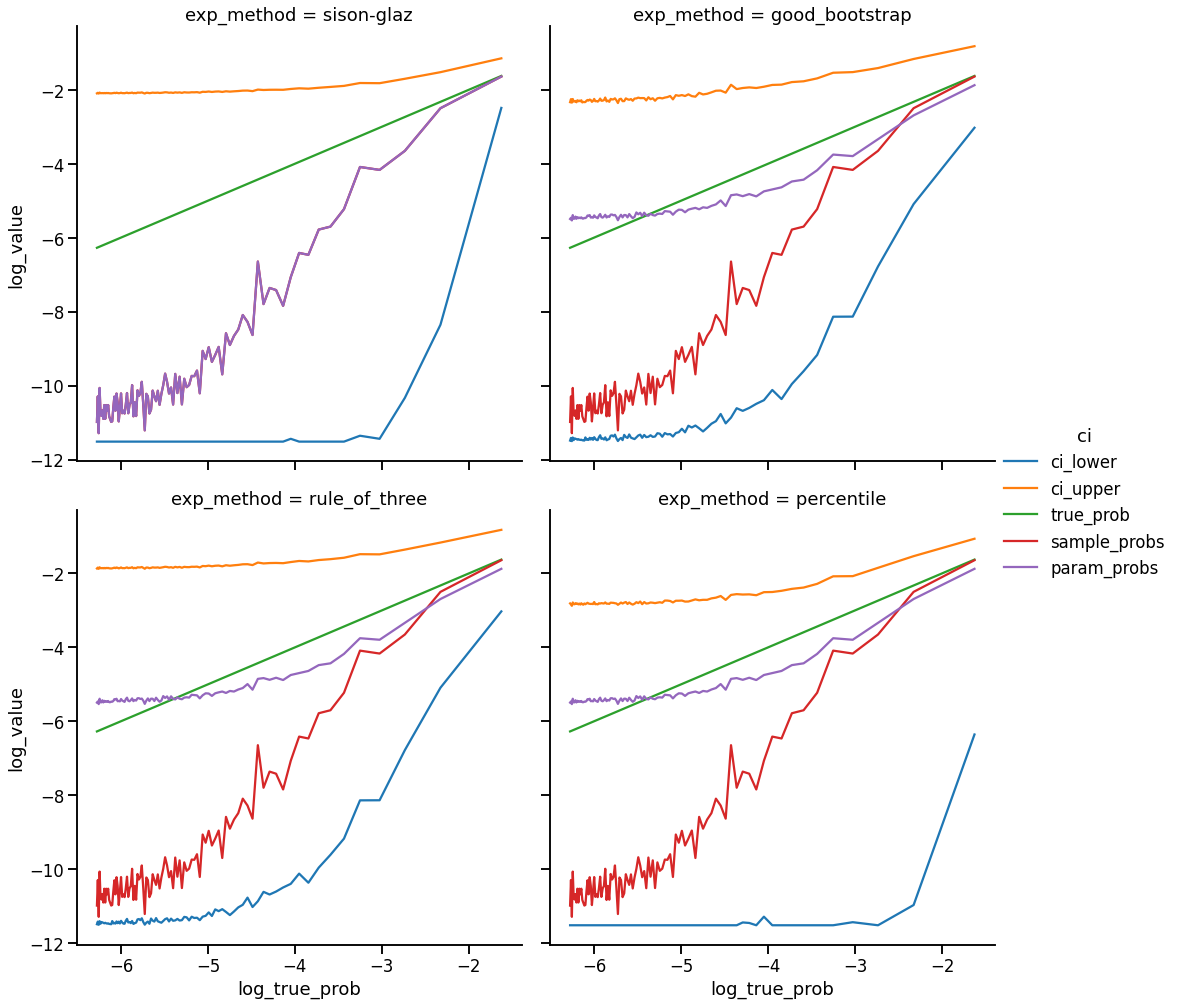

In [194]:

sns.relplot(x='log_true_prob', y='log_value', 
            hue='ci', col='exp_method', col_wrap=2, 
            kind='line', ci=None,
            height=7,
            data=exp_results_long)


In [195]:
in_ci_df = exp_results.assign(log_sample_probs=np.log(exp_results['sample_probs']+.00001)).\
groupby(['exp_num','exp_method','true_prob','log_true_prob', 'sample_probs', 'log_sample_probs', 
         'param_probs', 'ci_lower', 'ci_upper']).\
agg(in_ci = ('in_ci', 'mean'),
    count = ('true_prob', 'count')).reset_index()

in_ci_df

,exp_num,exp_method,true_prob,log_true_prob,sample_probs,log_sample_probs,param_probs,ci_lower,ci_upper,in_ci,count
0,0,good_bootstrap,0.001879,-6.277212,0.00,-11.512925,0.008083,0.000000,0.101695,1.0,1
1,0,good_bootstrap,0.001898,-6.267062,0.00,-11.512925,0.008083,0.000000,0.101695,1.0,1
2,0,good_bootstrap,0.001917,-6.256808,0.00,-11.512925,0.008083,0.000000,0.101695,1.0,1
3,0,good_bootstrap,0.001937,-6.246449,0.00,-11.512925,0.008083,0.000000,0.101695,1.0,1
4,0,good_bootstrap,0.001958,-6.235982,0.02,-3.911523,0.004520,0.000005,0.195390,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...
39995,99,sison-glaz,0.038715,-3.251523,0.02,-3.911523,0.020000,0.000000,0.156096,1.0,1
39996,99,sison-glaz,0.048502,-3.026148,0.08,-2.525604,0.080000,0.000000,0.216096,1.0,1
39997,99,sison-glaz,0.064856,-2.735589,0.12,-2.120180,0.120000,0.020000,0.256096,1.0,1
39998,99,sison-glaz,0.097679,-2.326069,0.10,-2.302485,0.100000,0.000000,0.236096,1.0,1


In [196]:
in_ci_df.groupby(['exp_method', 'true_prob']).\
agg(in_ci = ('in_ci', 'mean'),
    count = ('true_prob', 'count')).reset_index()


,exp_method,true_prob,in_ci,count
0,good_bootstrap,0.001879,1.00,100
1,good_bootstrap,0.001898,1.00,100
2,good_bootstrap,0.001917,1.00,100
3,good_bootstrap,0.001937,1.00,100
4,good_bootstrap,0.001958,1.00,100
...,...,...,...,...
395,sison-glaz,0.038715,0.99,100
396,sison-glaz,0.048502,1.00,100
397,sison-glaz,0.064856,1.00,100
398,sison-glaz,0.097679,0.96,100


In [197]:
in_ci_df[#(in_ci_df['in_ci']== False) &
         (in_ci_df['exp_method'].isin(['gt_orlitsky - our_soution_exact___',
                                      'gt_orlitsky - our_soution_boot___'])) 
        &(in_ci_df['exp_num']== 5)
        ][['param_probs', 'sample_probs', 'exp_method','ci_lower', 'ci_upper']].value_counts()#.sort_values('sample_probs', ascending=False)


Series([], dtype: int64)

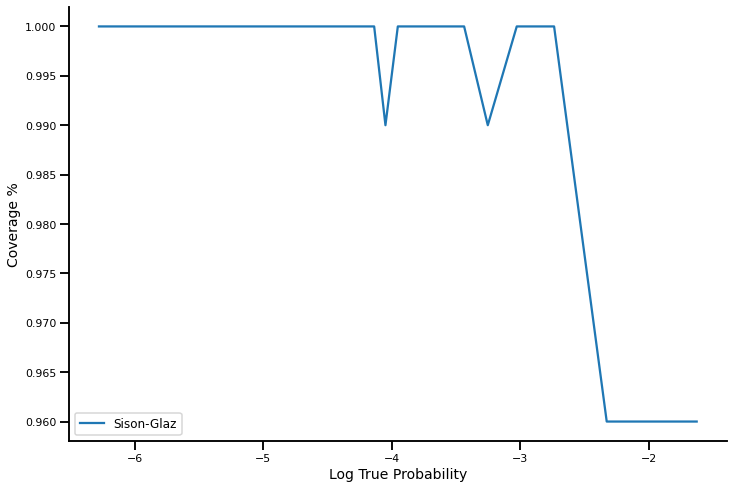

In [198]:
# fig, ax = plt.subplots()
# fig.set_size_inches(11.7, 8.27)
sns.set_context("talk")

g = sns.relplot(x='log_true_prob', y='in_ci',
                hue='exp_method', style='exp_method', #markers=True,
                kind='line', ci=None, #alpha=.55,
                height=7, aspect=1.5,
                legend=False,
                hue_order=['sison-glaz',
                              'gt_orlitsky - rule_pf_three___',
                              'gt_orlitsky - our_soution_boot___',
                              ],
            data=exp_results)
g.set_axis_labels("Log True Probability", 'Coverage %', size=14)

for ax in g.axes.flatten():
    ax.legend(labels=["Sison-Glaz", 'Rule of Three', 'Good Bootstrap'], fontsize=12, #title = "Method", 
              loc=3)
    ax.tick_params( labelsize=11)
# g.tight_layout()

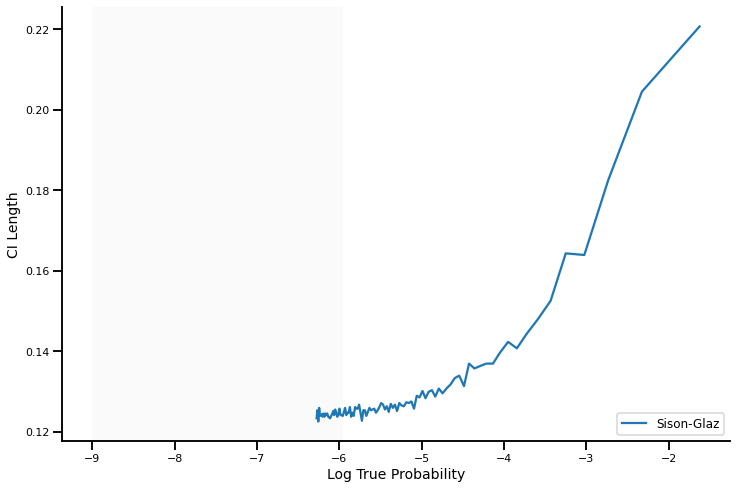

In [199]:
sns.set_context("talk")

g = sns.relplot(x='log_true_prob', y='ci_length',
                hue='exp_method', style='exp_method', #markers=True,
                kind='line', ci=None, #alpha=.55,
                height=7, aspect=1.5,
                legend=False,
                hue_order=['sison-glaz',
                              'gt_orlitsky - rule_pf_three___',
                              'gt_orlitsky - our_soution_boot___',
                              ],
            data=exp_results)
g.set_axis_labels("Log True Probability", 'CI Length', size=14)

for ax in g.axes.flatten():
    ax.legend(labels=["Sison-Glaz", 'Rule of Three', 'Good Bootstrap'], fontsize=12, #title = "Method", 
              loc=4)
    ax.tick_params( labelsize=11)
    ax.axvspan(-9, -5.952556, facecolor='lightgray', alpha=0.1)
# g.tight_layout()

<AxesSubplot:xlabel='sample_probs', ylabel='ci_length'>

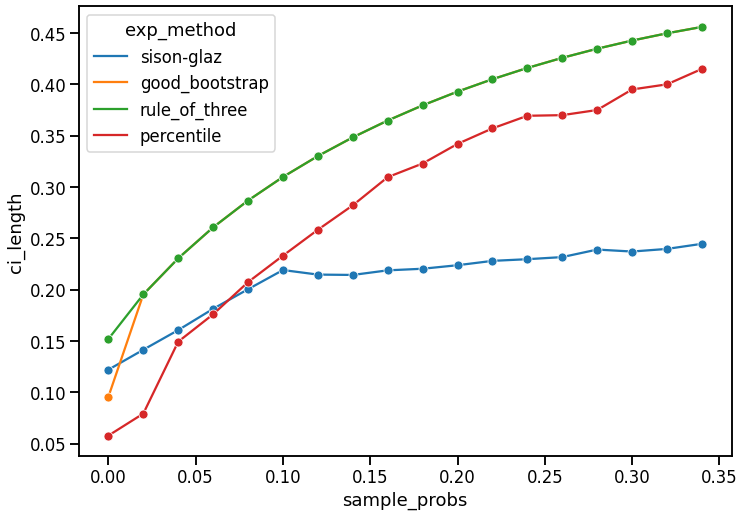

In [200]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.lineplot(x='sample_probs', y='ci_length', hue='exp_method',marker="o", ci=None,
            data=exp_results)

In [201]:
res_by_exp = exp_results.\
groupby(['exp_num','exp_method']).\
agg(in_ci = ('in_ci', 'sum'),
    ci_volume = ('ci_length', 'prod'),
    log_ci_volume = ('log_ci_length', 'sum')
).reset_index()
res_by_exp['all_in_ci'] = res_by_exp['in_ci'] == len(exp_word_list)
res_by_exp['ci_volume_log'] = np.log(res_by_exp['ci_volume'])
res_by_exp

,exp_num,exp_method,in_ci,ci_volume,log_ci_volume,all_in_ci,ci_volume_log
0,0,good_bootstrap,100,2.345915e-89,-204.077398,True,-204.077398
1,0,percentile,99,2.755096e-113,-259.178663,False,-259.178663
2,0,rule_of_three,100,5.236569e-78,-177.945971,True,-177.945971
3,0,sison-glaz,100,5.505555e-90,-205.526901,True,-205.526901
4,1,good_bootstrap,100,5.498795e-82,-187.107449,True,-187.107449
...,...,...,...,...,...,...,...
395,98,sison-glaz,100,3.588280e-93,-212.862741,True,-212.862741
396,99,good_bootstrap,100,2.520071e-92,-210.913542,True,-210.913542
397,99,percentile,100,6.303648e-118,-269.863913,True,-269.863913
398,99,rule_of_three,100,7.003228e-79,-179.957851,True,-179.957851


In [202]:
res_by_exp.groupby(['exp_method']).agg(all_word_coverage = ('all_in_ci', 'sum'),
                                       ci_volume_mean = ('ci_volume', 'mean'),
                                      log_ci_volume_mean = ('log_ci_volume', 'mean'))

,all_word_coverage,ci_volume_mean,log_ci_volume_mean
exp_method,,,
good_bootstrap,95,2.184053e-81,-216.121083
percentile,78,3.648626e-115,-270.617882
rule_of_three,97,1.825022e-78,-179.148146
sison-glaz,90,1.277593e-85,-204.606985
